# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [4]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [5]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [6]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [7]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


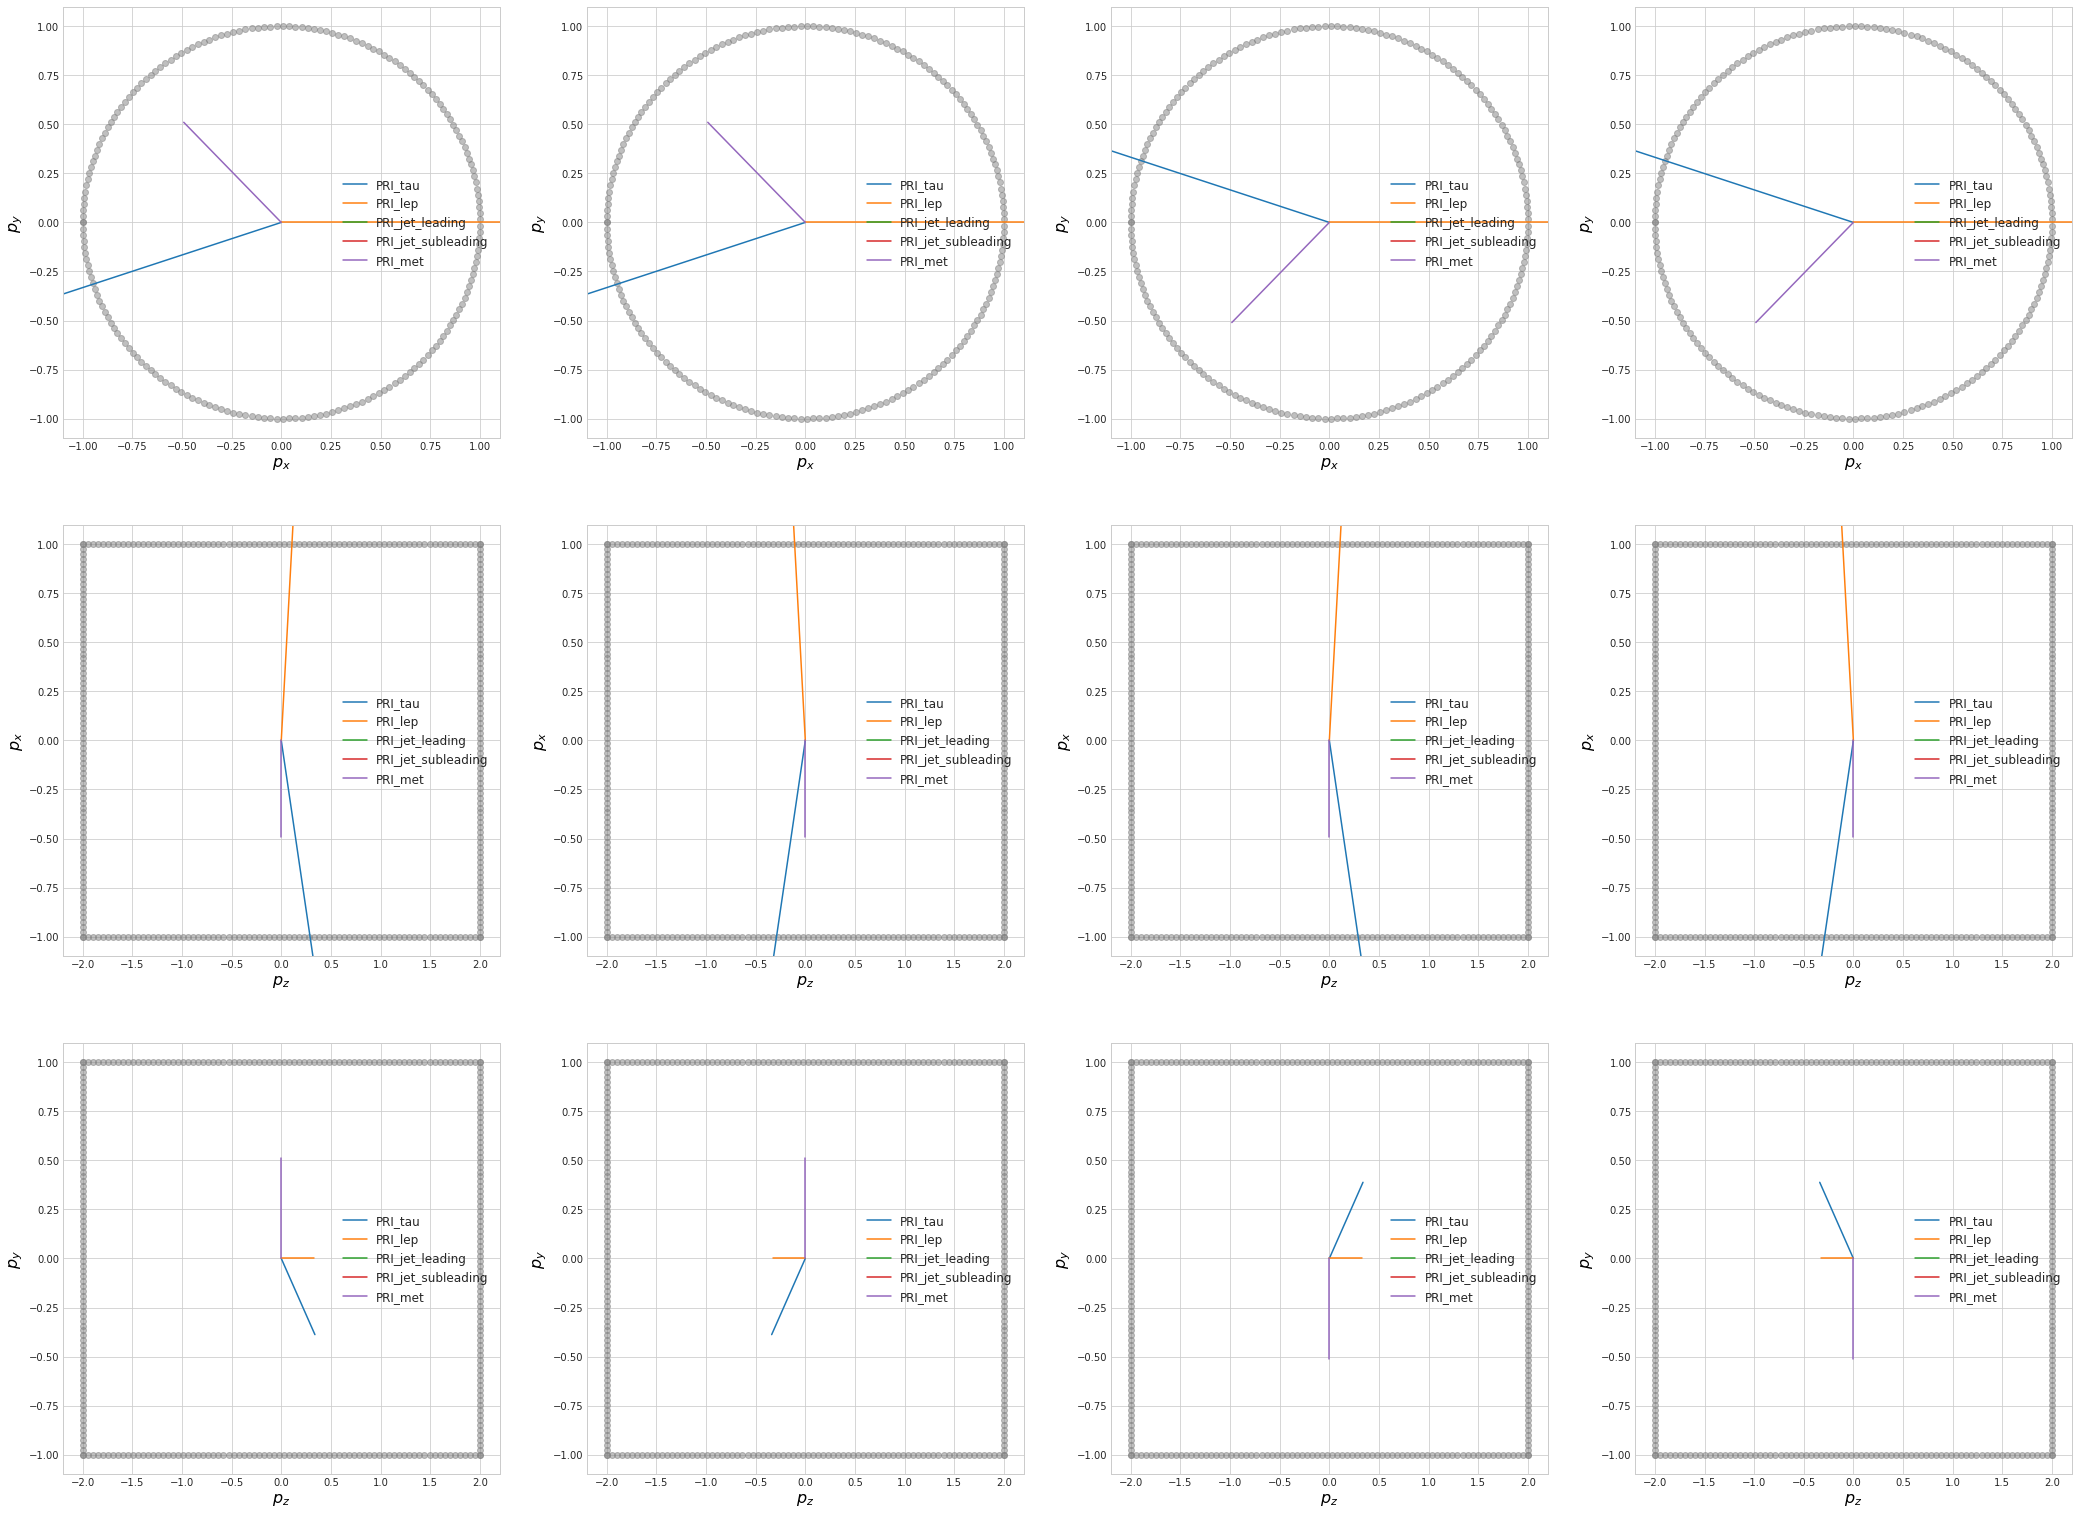

In [8]:
id=1
aug_ranges = [range(4)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.584s 


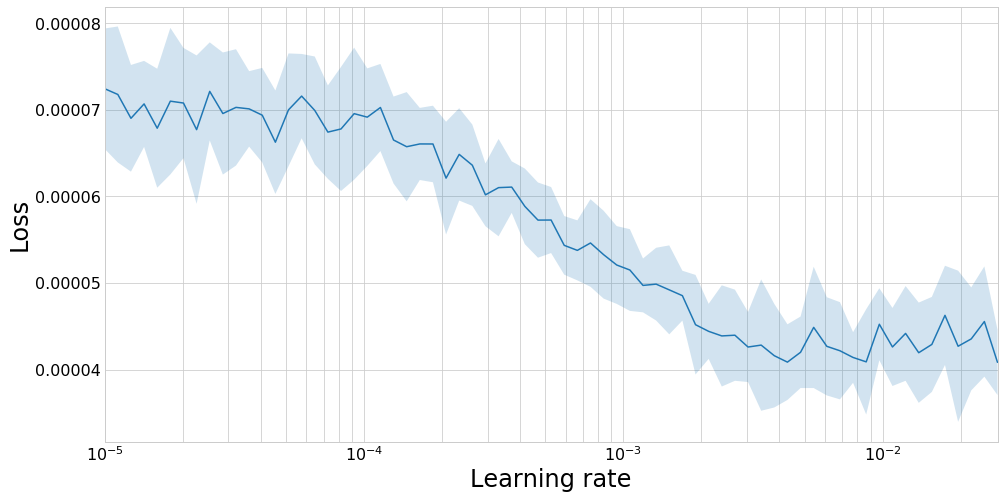

______________________________________



In [9]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [10]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227112). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114067). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6823517891753e-05
2 New best found: 3.497235418326454e-05
3 New best found: 3.45893095844076e-05
5 New best found: 3.382489185605664e-05
6 New best found: 3.330262573581422e-05
7 New best found: 3.3038536408275834e-05
10 New best found: 3.2890371045505165e-05
12 New best found: 3.268564077588963e-05
13 New best found: 3.245617450302234e-05
14 New best found: 3.233917308389209e-05
15 New best found: 3.2324899967352395e-05
22 New best found: 3.23153449135134e-05
26 New best found: 3.219205662317108e-05
27 New best found: 3.2078075647586956e-05
28 New best found: 3.205196352500934e-05
29 New best found: 3.200619838607963e-05
31 New best found: 3.2004047610098495e-05
50 New best found: 3.200132194469916e-05
51 New best found: 3.1956581144186203e-05
54 New best found: 3.184381824394222e-05
55 New best found: 3.176684698555619e-05
56 New best found: 3.1699970342742744e-05
59 New best found: 3.1696418064530005e-05
61 New best found: 3.1692754063988105e-05
106 New best foun

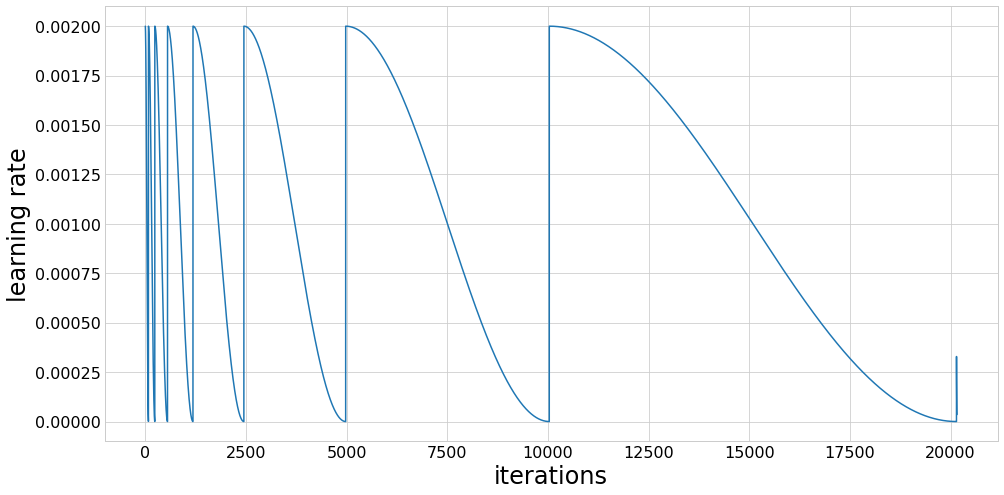

Fold took 223.242s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.218185). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109472). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8336093023826835e-05
2 New best found: 3.6447708928608334e-05
3 New best found: 3.5780557080579454e-05
5 New best found: 3.4794736841286065e-05
6 New best found: 3.415850396559108e-05
7 New best found: 3.4037801767408385e-05
11 New best found: 3.397191425610799e-05
13 New best found: 3.3650231815408915e-05
14 New best found: 3.337124584213598e-05
22 New best found: 3.3214426462654955e-05
24 New best found: 3.298252275853883e-05
25 New best found: 3.2841624211869205e-05
27 New best found: 3.2710657309507954e-05
50 New best found: 3.266259224474197e-05
52 New best found: 3.253458694380242e-05
59 New best found: 3.2461681806307755e-05
61 New best found: 3.243790261913091e-05
62 New best found: 3.242942282522563e-05
63 New best found: 3.242783901368966e-05
97 New best found: 3.2341358679695985e-05
106 New best found: 3.221444926748518e-05
108 New best found: 3.2181007821054665e-05
CosineAnneal stalling after 255 epochs, entering redux decay at LR=0.0004047999101731304
2

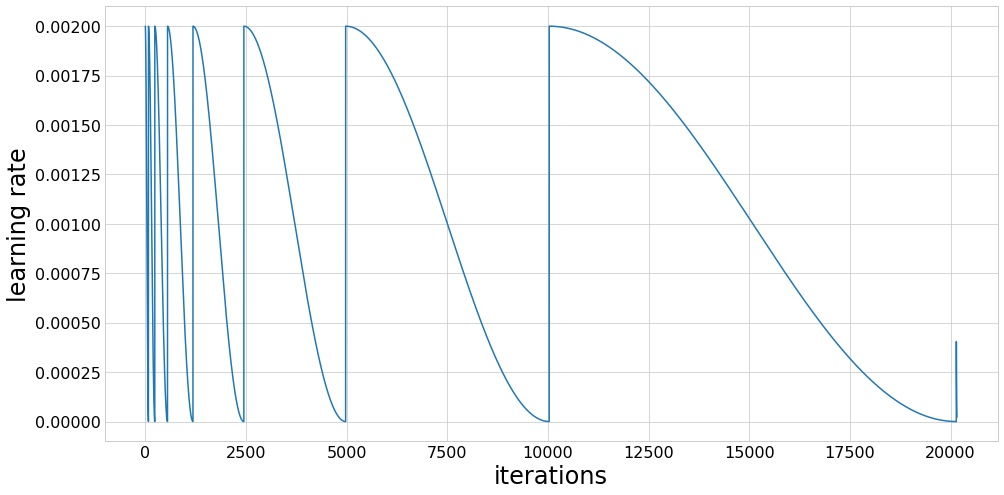

Fold took 233.574s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261651). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131221). Check your callbacks.
  % delta_t_median)


1 New best found: 3.712052133778343e-05
2 New best found: 3.459599508059909e-05
3 New best found: 3.384843288804405e-05
5 New best found: 3.366843584808521e-05
6 New best found: 3.304883248638362e-05
7 New best found: 3.242744371673325e-05
11 New best found: 3.237929481401807e-05
12 New best found: 3.233400613244157e-05
13 New best found: 3.204839703103062e-05
14 New best found: 3.198632413550513e-05
15 New best found: 3.194651689118473e-05
22 New best found: 3.19038445057231e-05
24 New best found: 3.184254091756884e-05
25 New best found: 3.164845603314461e-05
28 New best found: 3.156781546567799e-05
29 New best found: 3.156296509550885e-05
30 New best found: 3.152754028851632e-05
31 New best found: 3.151867924170802e-05
47 New best found: 3.15185749597731e-05
51 New best found: 3.138493575679604e-05
52 New best found: 3.1376558892952743e-05
54 New best found: 3.129693713999586e-05
55 New best found: 3.1294055560283596e-05
56 New best found: 3.128579833137337e-05
57 New best found: 3.1

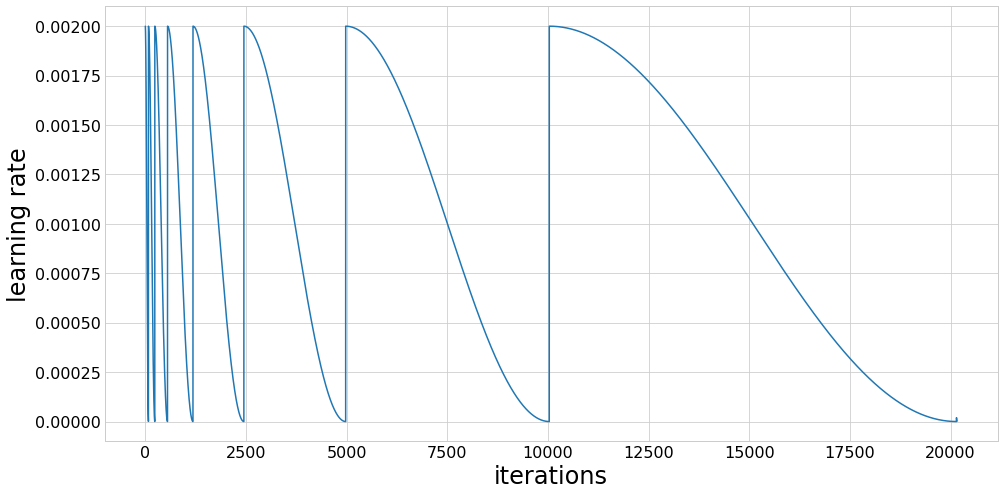

Fold took 239.858s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274273). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137526). Check your callbacks.
  % delta_t_median)


1 New best found: 3.877158758587584e-05
2 New best found: 3.573499582392165e-05
3 New best found: 3.495720449405709e-05
5 New best found: 3.359552645179179e-05
6 New best found: 3.3301945222410744e-05
7 New best found: 3.31435576817486e-05
11 New best found: 3.310839668796982e-05
12 New best found: 3.274707488028041e-05
13 New best found: 3.268722031394578e-05
14 New best found: 3.24596998306607e-05
23 New best found: 3.2422396184592554e-05
25 New best found: 3.233441587498274e-05
26 New best found: 3.212707798976152e-05
28 New best found: 3.204534970124711e-05
29 New best found: 3.202415469702559e-05
30 New best found: 3.201055392181622e-05
31 New best found: 3.200050614593228e-05
49 New best found: 3.184724384669052e-05
53 New best found: 3.183984503376263e-05
56 New best found: 3.177636784921839e-05
57 New best found: 3.177258143156321e-05
58 New best found: 3.175988886236605e-05
59 New best found: 3.1697690231022415e-05
102 New best found: 3.1552348164691886e-05
107 New best found:

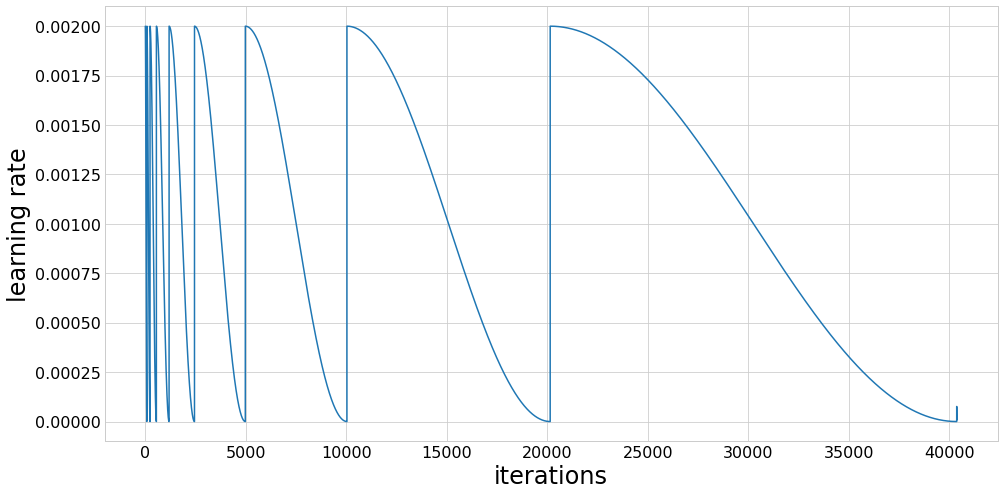

Fold took 480.047s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284661). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142752). Check your callbacks.
  % delta_t_median)


1 New best found: 3.88636784446293e-05
2 New best found: 3.664872728767459e-05
3 New best found: 3.5537444109514574e-05
4 New best found: 3.505715885256883e-05
5 New best found: 3.504906973765716e-05
6 New best found: 3.440080219252266e-05
7 New best found: 3.4295351156532674e-05
10 New best found: 3.4040623643136874e-05
11 New best found: 3.3959198926372185e-05
13 New best found: 3.357899904612624e-05
15 New best found: 3.353436988234606e-05
23 New best found: 3.338446569333505e-05
25 New best found: 3.313663239417213e-05
28 New best found: 3.29927222529363e-05
30 New best found: 3.2954556529971016e-05
31 New best found: 3.294725054761695e-05
47 New best found: 3.2818263021626793e-05
51 New best found: 3.279243350216069e-05
52 New best found: 3.277138865636907e-05
53 New best found: 3.262738523160106e-05
57 New best found: 3.2601297924618334e-05
61 New best found: 3.2569928054027114e-05
62 New best found: 3.256298300941371e-05
63 New best found: 3.2562191024210594e-05
93 New best foun

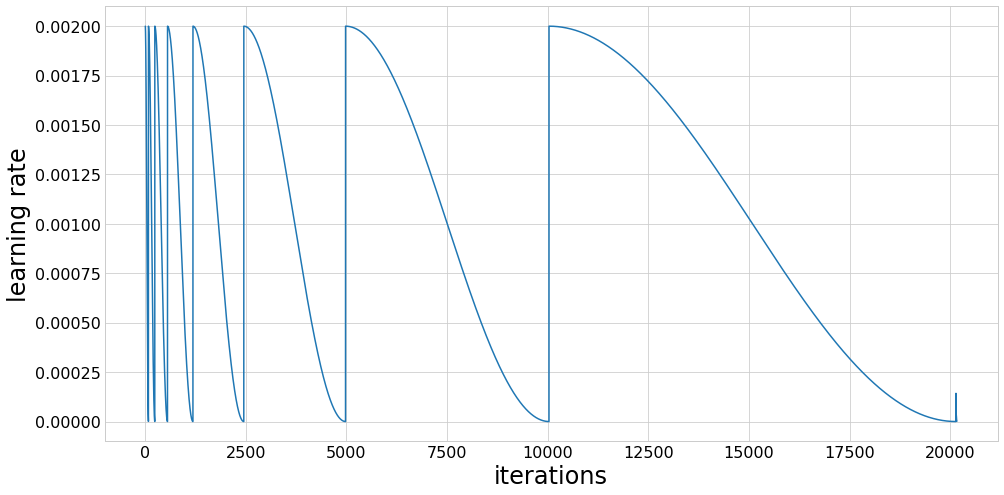

Fold took 262.313s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.305562). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153142). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6750037982130454e-05
2 New best found: 3.477080928465071e-05
3 New best found: 3.433052803343865e-05
5 New best found: 3.367068060948235e-05
6 New best found: 3.315036498781067e-05
7 New best found: 3.301775335253084e-05
10 New best found: 3.280145832438831e-05
11 New best found: 3.2776976833320184e-05
12 New best found: 3.238747677505752e-05
13 New best found: 3.2361066837219296e-05
14 New best found: 3.219897097040669e-05
23 New best found: 3.210996771690332e-05
25 New best found: 3.203068612125879e-05
26 New best found: 3.201576840965688e-05
27 New best found: 3.19485215977975e-05
28 New best found: 3.1721609613923133e-05
29 New best found: 3.1693715898623785e-05
30 New best found: 3.168674232563189e-05
31 New best found: 3.168255922573412e-05
47 New best found: 3.1623654220947786e-05
52 New best found: 3.15118516878961e-05
55 New best found: 3.1424696687303973e-05
56 New best found: 3.1345687570462234e-05
94 New best found: 3.128579750016383e-05
106 New best fou

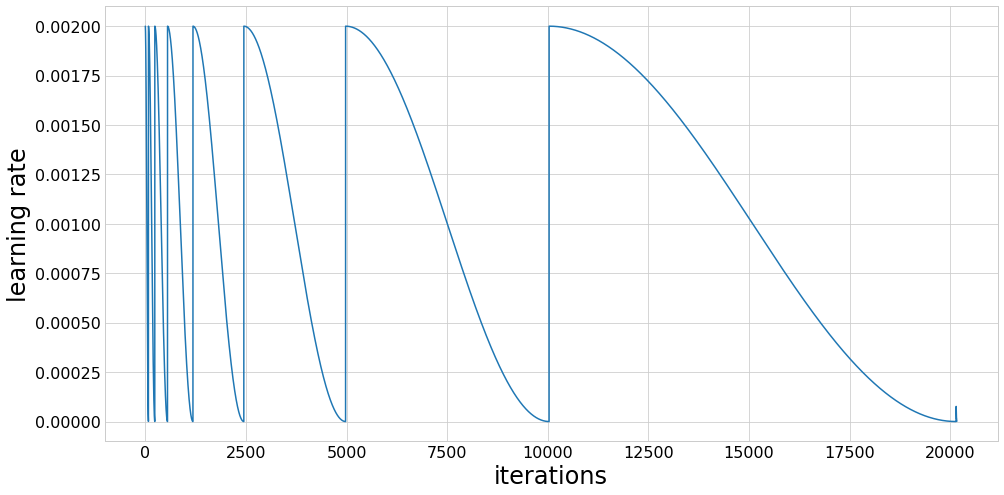

Fold took 265.798s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.344227). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172490). Check your callbacks.
  % delta_t_median)


1 New best found: 3.868657227285679e-05
2 New best found: 3.5136417694766975e-05
3 New best found: 3.440920293954762e-05
4 New best found: 3.41283370165632e-05
5 New best found: 3.336957695618718e-05
6 New best found: 3.311291884962451e-05
7 New best found: 3.276573902490102e-05
9 New best found: 3.2750584353030384e-05
11 New best found: 3.272980180198174e-05
12 New best found: 3.241500505950977e-05
13 New best found: 3.224107410568973e-05
14 New best found: 3.2223473193674355e-05
15 New best found: 3.2188008768658445e-05
24 New best found: 3.210131815378995e-05
26 New best found: 3.194310014323649e-05
27 New best found: 3.188079677687524e-05
29 New best found: 3.184388249770017e-05
30 New best found: 3.1822290647441574e-05
48 New best found: 3.1800059971451566e-05
54 New best found: 3.1760109251145925e-05
57 New best found: 3.16670149682602e-05
58 New best found: 3.16449073015764e-05
62 New best found: 3.1642064036229146e-05
63 New best found: 3.163901411116542e-05
108 New best found:

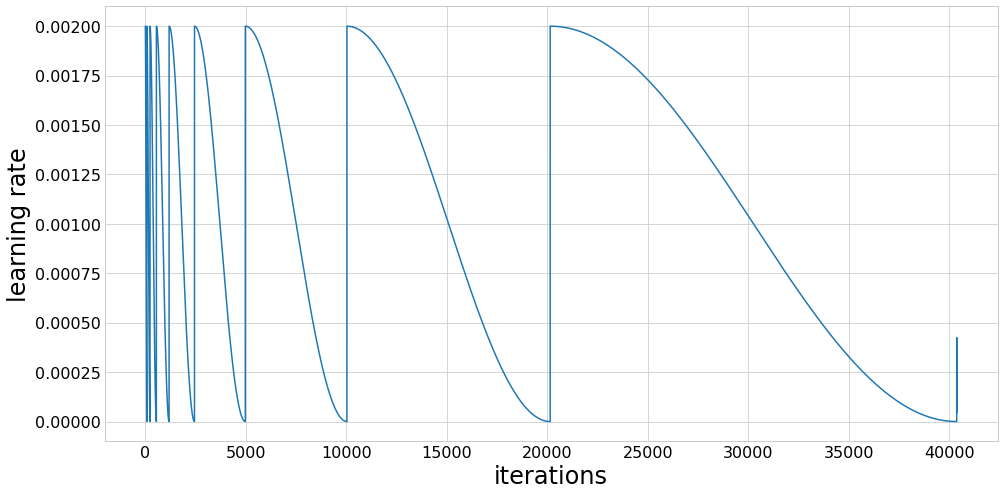

Fold took 508.576s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.373276). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.187002). Check your callbacks.
  % delta_t_median)


1 New best found: 3.706278790851971e-05
2 New best found: 3.624540824065726e-05
3 New best found: 3.4395646745976684e-05
5 New best found: 3.358930234578557e-05
6 New best found: 3.316653657364512e-05
7 New best found: 3.301663478595661e-05
11 New best found: 3.2568334742825165e-05
13 New best found: 3.24361615603173e-05
14 New best found: 3.2358818047837516e-05
15 New best found: 3.234243040680225e-05
25 New best found: 3.2139089106848546e-05
26 New best found: 3.2030062177400506e-05
28 New best found: 3.196280504265818e-05
30 New best found: 3.192861385742595e-05
52 New best found: 3.183974964967844e-05
53 New best found: 3.1779891990562334e-05
56 New best found: 3.17643565018135e-05
57 New best found: 3.17596173012824e-05
58 New best found: 3.1754361969670676e-05
59 New best found: 3.1750477386689186e-05
60 New best found: 3.174909988899796e-05
61 New best found: 3.171455875308851e-05
62 New best found: 3.17069964602656e-05
63 New best found: 3.1705768282194816e-05
97 New best found

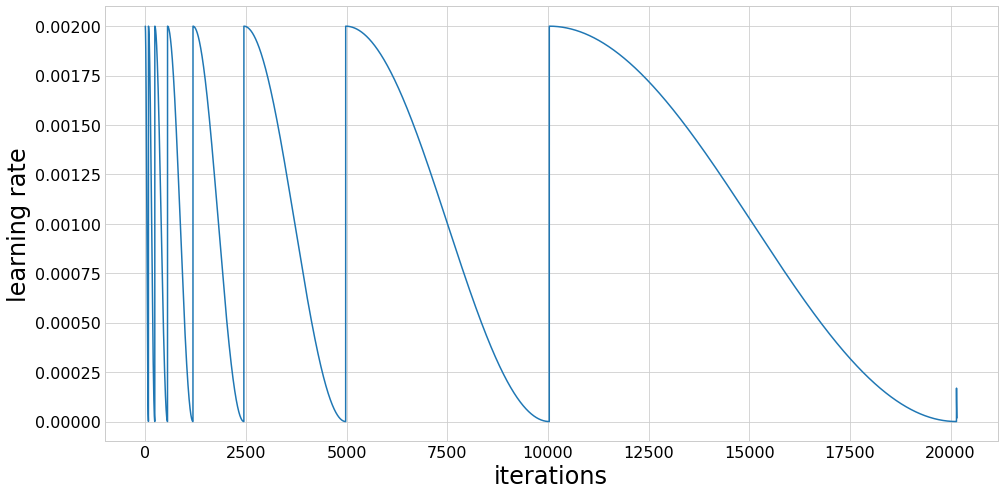

Fold took 265.055s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.386919). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193904). Check your callbacks.
  % delta_t_median)


1 New best found: 3.79531025951996e-05
2 New best found: 3.681811767267532e-05
3 New best found: 3.512875436225542e-05
5 New best found: 3.4321373251579125e-05
6 New best found: 3.3675918591884834e-05
7 New best found: 3.3566109238269326e-05
10 New best found: 3.338680855550951e-05
11 New best found: 3.3218339885654716e-05
12 New best found: 3.3055586666468336e-05
13 New best found: 3.280990949468523e-05
14 New best found: 3.2752228834277666e-05
15 New best found: 3.272866875526936e-05
25 New best found: 3.265820729061336e-05
26 New best found: 3.2605678852915827e-05
27 New best found: 3.257802732704335e-05
28 New best found: 3.2534451620109186e-05
29 New best found: 3.246744805945625e-05
30 New best found: 3.246483487208999e-05
51 New best found: 3.2453000895556404e-05
53 New best found: 3.22761904600913e-05
56 New best found: 3.222908891029263e-05
60 New best found: 3.222722914246455e-05
61 New best found: 3.2224430366124535e-05
62 New best found: 3.222303527509361e-05
63 New best fo

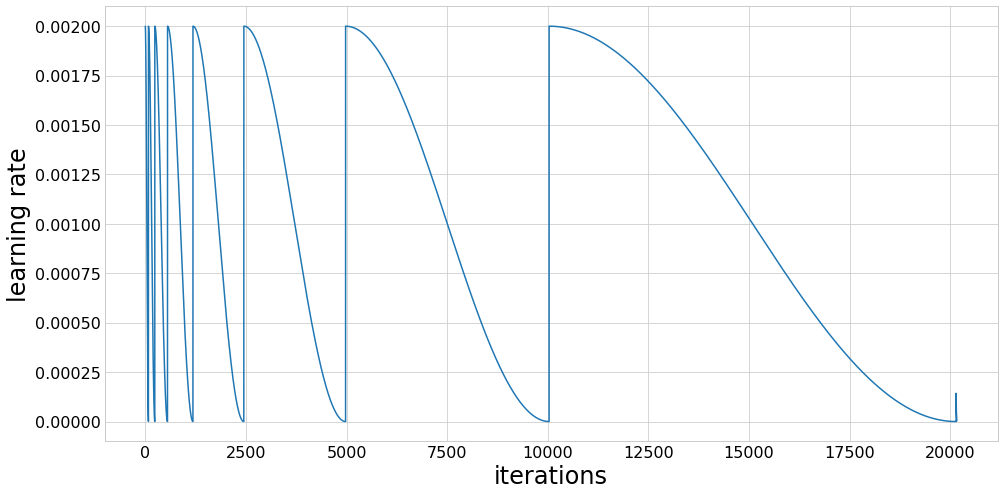

Fold took 279.501s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408158). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204516). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7742558121681215e-05
2 New best found: 3.6297451386053584e-05
3 New best found: 3.508765017177211e-05
5 New best found: 3.4256075897428674e-05
6 New best found: 3.37267458657152e-05
7 New best found: 3.3698983675276394e-05
10 New best found: 3.349245306744706e-05
11 New best found: 3.3460781910980585e-05
12 New best found: 3.320073449285701e-05
13 New best found: 3.29889570173691e-05
14 New best found: 3.28957068733871e-05
15 New best found: 3.286316286539659e-05
23 New best found: 3.276336897688452e-05
25 New best found: 3.2717538125871214e-05
26 New best found: 3.267655094969086e-05
27 New best found: 3.247831558692269e-05
30 New best found: 3.244679306735634e-05
31 New best found: 3.243863832904026e-05
49 New best found: 3.242396258428926e-05
50 New best found: 3.234151049837237e-05
53 New best found: 3.219465688307537e-05
58 New best found: 3.212733727341402e-05
60 New best found: 3.211687838411308e-05
61 New best found: 3.211134253506316e-05
62 New best found: 

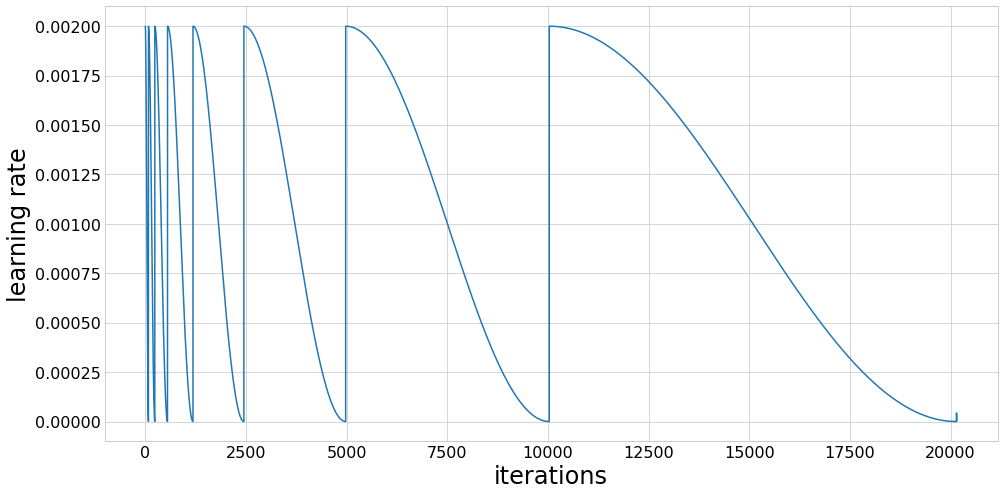

Fold took 278.104s


______________________________________
Training finished
Cross-validation took 3038.932s 


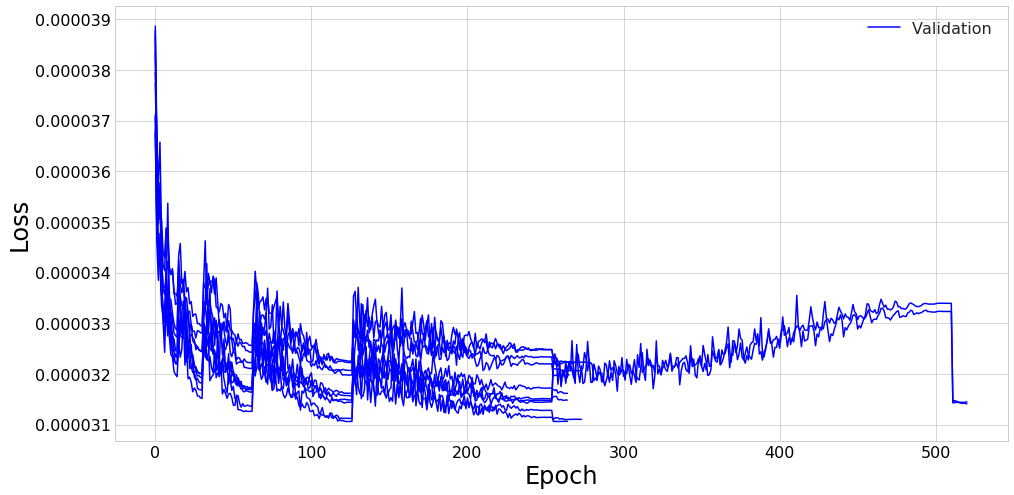

Mean loss = 3.16e-05 +- 1e-07
Mean wAUC = 0.0629 +- 0.0005
Mean AUC = 0.0981 +- 0.0006
Mean AMS = 3.86 +- 0.06
Mean cut = 0.955 +- 0.004
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [12]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [13]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 2 with loss = 3.106083838065388e-05
Model 1 is 5 with loss = 3.109911800511554e-05
Model 2 is 6 with loss = 3.139397633376671e-05
Model 3 is 3 with loss = 3.142013487651443e-05
Model 4 is 7 with loss = 3.147406224231458e-05
Model 5 is 0 with loss = 3.160318289301358e-05
Model 6 is 9 with loss = 3.1964332906500206e-05
Model 7 is 8 with loss = 3.204871499242861e-05
Model 8 is 1 with loss = 3.217949577665422e-05
Model 9 is 4 with loss = 3.222939562216392e-05


## Response on validation data without TTA

In [14]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [15]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0018788033779710532s per sample

Predicting fold 2 out of 10
Prediction took 0.00040919475108385086s per sample

Predicting fold 3 out of 10
Prediction took 0.00039135857820510865s per sample

Predicting fold 4 out of 10
Prediction took 0.00039481372572481633s per sample

Predicting fold 5 out of 10
Prediction took 0.0003913458488881588s per sample

Predicting fold 6 out of 10
Prediction took 0.0004037894327193499s per sample

Predicting fold 7 out of 10
Prediction took 0.00039627556800842287s per sample

Predicting fold 8 out of 10
Prediction took 0.0003937932085245848s per sample

Predicting fold 9 out of 10
Prediction took 0.00039507760852575303s per sample

Predicting fold 10 out of 10
Prediction took 0.0003926263727247715s per sample



In [16]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [17]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9041067547058935, weighted 0.9364252718268142


Best cut at 0.9644059850885585 corresponds to AMS of 3.9045949719982023
Maximum AMS for data is 3.9722599869270985 at cut of 0.9650787711143494
CPU times: user 26.1 s, sys: 0 ns, total: 26.1 s
Wall time: 26.1 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


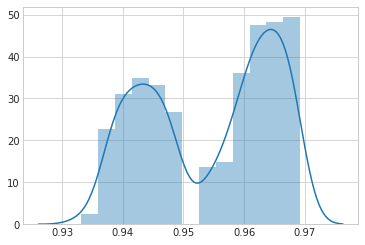

In [18]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95450276 corresponds to AMS of 3.780257100578129
Maximum AMS for data is 3.9722599869270985 at cut of 0.9650787711143494
CPU times: user 90.6 ms, sys: 42.4 ms, total: 133 ms
Wall time: 78.8 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


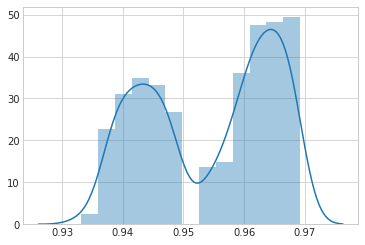

In [19]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [20]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [21]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0016032616432756185s per sample

Predicting fold 2 out of 10
Prediction took 0.0015911746069788932s per sample

Predicting fold 3 out of 10
Prediction took 0.0016026745337992907s per sample

Predicting fold 4 out of 10
Prediction took 0.0015918906431645155s per sample

Predicting fold 5 out of 10
Prediction took 0.001589540723338723s per sample

Predicting fold 6 out of 10
Prediction took 0.001597946285456419s per sample

Predicting fold 7 out of 10
Prediction took 0.0015892584078013897s per sample

Predicting fold 8 out of 10
Prediction took 0.0015955519150942564s per sample

Predicting fold 9 out of 10
Prediction took 0.0016088610157370567s per sample

Predicting fold 10 out of 10
Prediction took 0.0015997436728328466s per sample



In [22]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [23]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9042224700160513, weighted 0.9364787786948456


Best cut at 0.9642682258073274 corresponds to AMS of 3.9135992042752608
Maximum AMS for data is 4.002526814708789 at cut of 0.9652550220489502
CPU times: user 25.9 s, sys: 2.53 ms, total: 25.9 s
Wall time: 25.9 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


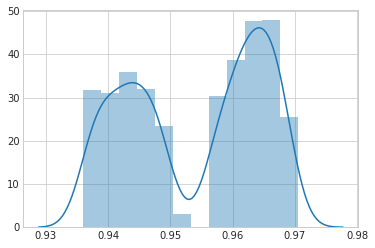

In [24]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9541124 corresponds to AMS of 3.728990443306858
Maximum AMS for data is 4.002526814708789 at cut of 0.9652550220489502
CPU times: user 92.1 ms, sys: 34.3 ms, total: 126 ms
Wall time: 80.9 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


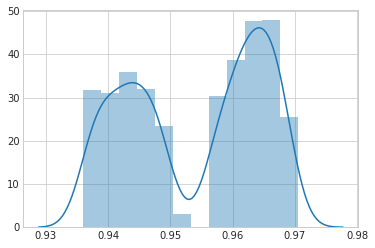

In [25]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [26]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [27]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00038927931419827723s per sample

Predicting fold 2 out of 10
Prediction took 0.00039103309529071504s per sample

Predicting fold 3 out of 10
Prediction took 0.00038937682092867116s per sample

Predicting fold 4 out of 10
Prediction took 0.00038967614123089746s per sample

Predicting fold 5 out of 10
Prediction took 0.00038774473294615747s per sample

Predicting fold 6 out of 10
Prediction took 0.00038875196488066154s per sample

Predicting fold 7 out of 10
Prediction took 0.00038694147464226594s per sample

Predicting fold 8 out of 10
Prediction took 0.00038982381681826984s per sample

Predicting fold 9 out of 10
Prediction took 0.0003909776977517388s per sample

Predicting fold 10 out of 10
Prediction took 0.00038983784846284173s per sample

CPU times: user 3min 54s, sys: 6.08 s, total: 4min
Wall time: 3min 34s


In [28]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.609337217300639 : 3.7420261840832767


(3.609337217300639, 3.7420261840832767)

In [29]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.775821566320768 : 3.777460067999588


(3.775821566320768, 3.777460067999588)

# Test scoring - With TTA

In [30]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [31]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0015594233096661893s per sample

Predicting fold 2 out of 10
Prediction took 0.0015581295129250396s per sample

Predicting fold 3 out of 10
Prediction took 0.0015544538978825915s per sample

Predicting fold 4 out of 10
Prediction took 0.0015651177317242732s per sample

Predicting fold 5 out of 10
Prediction took 0.0015614948702468113s per sample

Predicting fold 6 out of 10
Prediction took 0.0015630575599995527s per sample

Predicting fold 7 out of 10
Prediction took 0.0015704450138590554s per sample

Predicting fold 8 out of 10
Prediction took 0.0015602131387726828s per sample

Predicting fold 9 out of 10
Prediction took 0.0015656237912110306s per sample

Predicting fold 10 out of 10
Prediction took 0.0015589735462245616s per sample

CPU times: user 15min 39s, sys: 23.4 s, total: 16min 3s
Wall time: 14min 18s


In [32]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.611171747355865 : 3.746095393173964


(3.611171747355865, 3.746095393173964)

In [33]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.7757464657638034 : 3.7908598077265827


(3.7757464657638034, 3.7908598077265827)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)